<a href="https://www.kaggle.com/awsaf49/seti-bl-tf-starter-tpu?scriptVersionId=83054112" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# [SETI Breakthrough Listen - E.T. Signal Search](https://www.kaggle.com/c/seti-breakthrough-listen)
>Find extraterrestrial signals in data from deep space 

![](https://storage.googleapis.com/kaggle-competitions/kaggle/23652/logos/header.png?t=2021-02-24-19-15-30)

# A. Version Info 🚩
* `v9`  : moved from **StratifiedKFold** by group to **KFold** as those folder(groups) don't have any signifance.
* `v10` : **KFold** to **StratifiedKFold**
* `v11` : no resize, augmentation updated for non-square image

# B. Resource 🍰

* Notebook for Dataset
    * [SETI-BL: 256x256 tfrec Data](https://www.kaggle.com/awsaf49/seti-bl-256x256-tfrec-data)


* Datasets
    * [128x128](https://www.kaggle.com/awsaf49/setibl-128x128-tfrec-dataset)
    * [256x256](https://www.kaggle.com/awsaf49/setibl-256x256-tfrec-dataset)
    * [384x384](https://www.kaggle.com/awsaf49/setibl-384x384-tfrec-dataset)

# 0. Methodology 📌
* This notebook demonstrates how can we use **CNN** to classify the signals.
* Even though at first glance this problems seems like **signal** detection problem, but we can convert this to be a image classification problem. We can convert 1D signal to 2D signal(image) using different methods such as **Fourier Transform** which basically converts data from **time** domain to **frequency** domain. So, from `[time, intensity]` we get `[time, frequency, intensity]`. Luckily, we are given such 2D info; so we don't have to convert anything.

* This notebook uses pre-computed **tfrecord** for training. **TFRecord** can scale up training upto 2x. With **TPU** as our device, this can save our good amount of time.
* For augmentation, **Rotation, Flip, Shear, Zoom, Shift, Dropout, RandomJitter** is used.
* This notebook uses **EfficientNet** as backbone model (classifier).
* Then, we calculate **Out of Fold (OOF)** score of this notebook.
* Finally, we make our **Submission**.

# 1. Install Libraries 🛠

In [1]:
!pip install -q efficientnet >> /dev/null

# 2. Import Libraries 📚

In [2]:
import pandas as pd, numpy as np, random,os, shutil
from glob import glob
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
print('tf:',tf.__version__)

2021-12-23 02:30:26.897297: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-23 02:30:26.897423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tf: 2.4.1


# 3. Notebook Config ⚙️

In [3]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE      = 0
DISPLAY_PLOT = True

DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 2, 5, 10
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
IMG_SIZES = [[273, 256]]*FOLDS

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS      = [12]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6]*FOLDS

# Augmentations
AUGMENT   = True
TRANSFORM = True

# AFFINE TRANSFORMATION
ROT_    = 0.0 # ROTATION
SHR_    = 2.0 # SHEAR
HZOOM_  = 8.0 # HORIZONTAL ZOOM
WZOOM_  = 8.0 # VERTICAL ZOOM
HSHIFT_ = 8.0 # HORIZONTAL SHIFT
WSHIFT_ = 8.0 # VERTICAL SHIFT

# COARSE DROPOUT - MORE ABOUT THIS IS LATER
PROBABILITY = 0.50 # PROBABILITY OF DROPOUT
CT          = 8 # NUMBER OF DROPOUTS
SZ          = 0.05 # SIZE OF THE DROPOUT - CALCULATED AS PERCENT OF IMAGE-DIMENSION

#bri, contrast
sat  = (0.7, 1.3) # SATURATION
cont = (0.8, 1.2) # CONTRAST
bri  =  0.1 # BRIGHTNESS

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

## Reproducibility 

In [4]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(SEED)

seeding done!!!


# 4. Set Up Device 📱
Following codes automatically detects hardware(tpu or gpu or cpu). 
* **What is TPU ?**: They are hardware accelerators specialized in deep learning tasks. They are equipped with 128GB of high-speed memory allowing larger batches, larger models and also larger training inputs. To know more about tpu, checkout this [doc](https://www.kaggle.com/docs/tpu).

<img src="https://storage.googleapis.com/kaggle-media/tpu/tpu_cores_and_chips.png" width=600>

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            # instantiate a distribution strategy
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    # instantiate a distribution strategy
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...


2021-12-23 02:30:33.035601: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-23 02:30:33.039364: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-23 02:30:33.039423: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-23 02:30:33.039456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (590f0448058a): /proc/driver/nvidia/version does not exist
2021-12-23 02:30:33.042693: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

TPU initialized
REPLICAS: 8


# 5. Preprocess 🧂
**NOTE:**
* Original Signal had **6** channels. I only took **3** as it was mention here,
```
Not all of the “needle” signals look like diagonal lines, and they may not be present for the entirety of all three “A” observations, but what they do have in common is that they are only present in some or all of the “A” observations (panels 1, 3, and 5 in the cadence snippets).
```
*  Didn't do any **Signal Processing** so far. Left it for the model.
*  Used simple augmentations, some of them may hurt the model.

In [6]:
GCS_PATH = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('setibl-%ix%i-tfrec-dataset'%(k[0],k[1]))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))
num_train_files = len(files_train)
num_test_files  = len(files_test)
print('train_files:',num_train_files)
print('test_files:',num_test_files)

train_files: 20
test_files: 10


2021-12-23 02:30:41.421033: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:30:41.516285: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


## Meta Data
* `train/` - a training set of cadence snippet files stored in **numpy float16** format (v1.20.1), one file per cadence snippet id, with corresponding labels found in the train_labels.csv file. Each file has dimension `(6, 273, 256)`, with the 1st dimension representing the 6 positions of the cadence, and the 2nd and 3rd dimensions representing the 2D spectrogram.
* `test/` - the test set cadence snippet files; you must predict whether or not the cadence contains a "needle", which is the target for this competition
* `sample_submission.csv` - a sample submission file in the correct format
* `train_labels` - targets corresponding (by id) to the cadence snippet files found in the train/ folder
* `old_leaky_data` - full pre-relaunch data, including test labels; you should not assume this data is helpful (it may or may not be).


In [7]:
train_label_df = pd.read_csv('../input/c/seti-breakthrough-listen/train_labels.csv')
test_label_df  = pd.read_csv('../input/c/seti-breakthrough-listen/sample_submission.csv')

train_paths = glob('../input/c/seti-breakthrough-listen/train/**/*.npy')
test_paths = glob('../input/c/seti-breakthrough-listen/test/**/*.npy')

train_df = pd.DataFrame({'filepath':train_paths})
train_df['id'] = train_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
train_df['group'] = train_df.filepath.map(lambda x: x.split('/')[-2])
train_df = pd.merge(train_df, train_label_df, on='id', how='left')

print(f'num_train: {len(train_paths)}\nnum_test : {len(test_paths)}')

num_train: 60000
num_test : 39995


## Class Distribution
* **Tfrecord** dataset has total **20** files and for proper validatoin scheme, each has been made stratifing `target` & `group` feature. 

In [8]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

fig = go.Figure(data=[
    go.Bar(name='haystack', 
           y=train_df.target.value_counts().values[0:1],
           x=['haystack'],
           text = train_df.target.value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='needle', 
           y=train_df.target.value_counts().values[1:],
           x=['needle'],
           text = train_df.target.value_counts()[1:],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of Images',
                  xaxis_title='Class Name',)
iplot(fig)

# 6. Data Augmentation 🌈
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

As this is not typical **image** data rather **signal** typical augmantation for **image** may do some damage

In [9]:
# Augmentations by @cdeotte
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=IMG_SIZES[0]):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    
    # fixed for non-square image thanks to Chris Deotte
    
    if DIM[0]!=DIM[1]:
        pad = (DIM[0]-DIM[1])//2
        image = tf.pad(image, [[0, 0], [pad, pad+1],[0, 0]])
        
    NEW_DIM = DIM[0]
    
    XDIM = NEW_DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(NEW_DIM//2, -NEW_DIM//2,-1), NEW_DIM)
    y   = tf.tile(tf.range(-NEW_DIM//2, NEW_DIM//2), [NEW_DIM])
    z   = tf.ones([NEW_DIM*NEW_DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -NEW_DIM//2+XDIM+1, NEW_DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([NEW_DIM//2-idx2[0,], NEW_DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
    
    if DIM[0]!=DIM[1]:
        image = tf.reshape(d,[NEW_DIM, NEW_DIM,3])
        image = image[:, pad:DIM[1]+pad,:]
    image = tf.reshape(image, [*DIM, 3])
        
    return image

## Dropout
check this [notebook](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169721) by chris for more explanation on **Coarse Dropout and Cutout**

![](http://playagricola.com/Kaggle/drop-7-24.jpg)

Coarse Dropout and Cutout augmentation are techniques to prevent **overfitting** and encourage generalization. They randomly remove rectangles from training images. By removing portions of the images, we challenge our models to pay attention to the entire image because it never knows what part of the image will be present. (This is similar and different to dropout layer within a **CNN**).

* Cutout is the technique of removing 1 large rectangle of random size
* Coarse dropout is the technique of removing many small rectanges of similar size.

By changing the parameters below, we can have either coarse dropout or cutout. (For cutout, you'll need to add tf.random.uniform for random size. I leave this as an exercise for the reader.

In [10]:
# by cdotte
def dropout(image,DIM=IMG_SIZES[0], PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0) 

    image = tf.reshape(image,[*DIM,3])
    return image

## Reading TFRecord Data
**So, ever wondered why people use TFRecord?**

* The **TFRecord** (`.tfrecord`/`.tfrec`) format is TensorFlow's custom data format which is used for storing a sequence of binary records. 
* TFRecord data takes up **less space on the storage disk**, and **takes less time to read and write from the disk**.
* There are a number of advantages to using TFRecords: 
    * More efficient storage
    * Fast I/O
    * Self-contained files
    * TPUs require that you pass data to them in TFRecord format
    
## tf.data
To build data pipeline using `tfrecrod` we need to use `tf.data` API. **So, what is `tf.data` ?**

* The `tf.data` API enables us to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random transformation to each image, and merge randomly selected images into a batch for training.

* The `tf.data` API provides a `tf.data.Dataset` abstraction that represents a sequence of elements where each element comprises one or more components. For instances, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

Checkout this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.


In [11]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_id):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_id'] if return_image_id else 0

 
def prepare_image(img, augment=True, dim=IMG_SIZES[0]):    
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = img/255.0 # rescale image
    
    if augment:
        img = transform(img,DIM=dim) if TRANSFORM else img
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, sat[0], sat[1])
        img = tf.image.random_contrast(img, cont[0], cont[1])
        img = tf.image.random_brightness(img, bri)     
                      
    img = tf.reshape(img, [*dim, 3])
            
    return img

def count_data_items(fileids):
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) 
         for fileid in fileids]
    return np.sum(n)

# 7. Data Pipeline 🍚
* Read **TFRecord** files.
* `cache` data to speed up the training.
* `repeat` the data stream (for training only & test-time augmentation).
* `shuffle` the data (for training only).
* Unparse **tfrecord** data.
* Decode data from ByteString to Image Data.
* Process Image Data (Rescale).
* Apply Augmentations.
* Batch Data.


In [12]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_ids=True, batch_size=16, dim=IMG_SIZES[0]):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO) # read tfrecord
    ds = ds.cache() # cache data for speedup
    
    if repeat:
        ds = ds.repeat() # repeat the data (for training only)
    
    if shuffle: 
        ds = ds.shuffle(1024*2, seed=SEED) # shuffle the data (for training only)
        opt = tf.data.Options()
        opt.experimental_deterministic = False # order won't be maintained when we shuffle
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO) # unparse tfrecord data with labels
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_ids), 
                    num_parallel_calls=AUTO)      # unparse tfrecord data without labels
    
    ds = ds.map(lambda img, imgid_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgid_or_label),  # get img from bytestring, augmentations
                num_parallel_calls=AUTO)
    if labeled and augment:
        ds = ds.map(lambda img, label: (dropout(img, DIM=dim, PROBABILITY = PROBABILITY, CT = CT, SZ = SZ), label),
                    num_parallel_calls=AUTO)  # use dropout only in training
    
    ds = ds.batch(batch_size * REPLICAS) # batch the data
    ds = ds.prefetch(AUTO) # prefatch data for speedup
    return ds

## Visualization

In [13]:
def display_batch(batch, size=3):
    imgs, tars = batch
    for img_idx in range(size):
        plt.figure(figsize=(5*2, 15*2))
        for idx in range(3):
            plt.subplot(size, 3, idx+1)
            plt.title(f'id:{tars[img_idx].numpy().decode("utf-8")}')
            plt.imshow(imgs[img_idx,:, :, idx])
            plt.text(5, 15, str(idx), bbox={'facecolor': 'white'})
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show() 

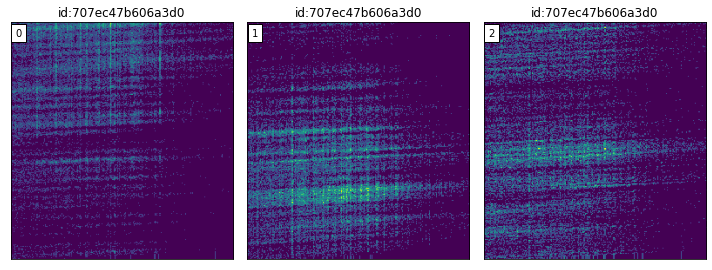

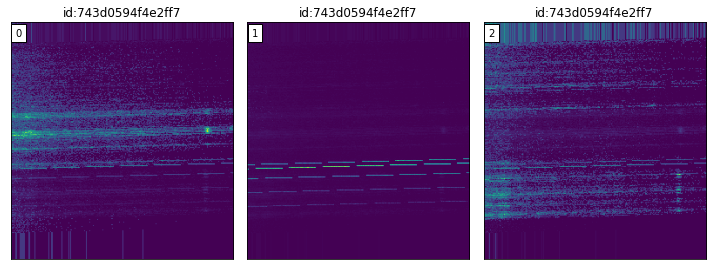

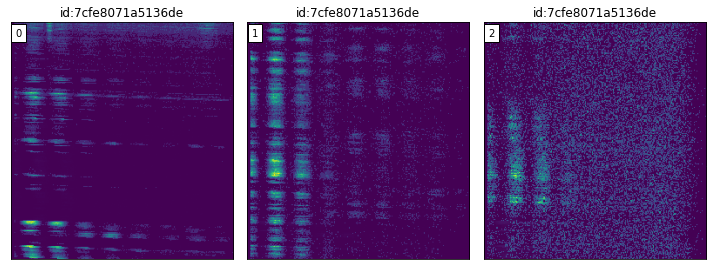

In [14]:
fold = 0
ds = get_dataset(files_train, augment=True, shuffle=False, repeat=True,labeled=False,return_image_ids=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold])
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 3);

# 8. Build Model 📦
>Though there have been some amazing development, **EFficientNet** always come up with a decent score.

![EffNet](https://1.bp.blogspot.com/-MQO5qKuTT8c/XpdE8_IwpsI/AAAAAAAAFtg/mSjhF2ws5FYxwcHN6h9_l5DqYzQlNYJwwCLcBGAsYHQ/s1600/image1.png)

You can try other models like, 
* Vision Transformer (ViT)
* ResNet
* InceptionNet
* XceptionNet

In [15]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=IMG_SIZES[0], ef=0):
    inp = tf.keras.layers.Input(shape=(*dim,3)) # input layer with propoer img-dimension
    base = EFNS[ef](input_shape=(*dim,3),weights='imagenet',include_top=False) # get base model (efficientnet), use imgnet weights
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # use GAP to get pooling result form conv outputs
    x = tf.keras.layers.Dense(32, activation = 'relu')(x) # use activation to apply non-linearity
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x) # use sigmoid to convert predictions to [0-1]
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)  # label smoothing for robustness
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# 8. LR Schedule ⚓
* This is a common train schedule for transfer learning. 
* The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes.

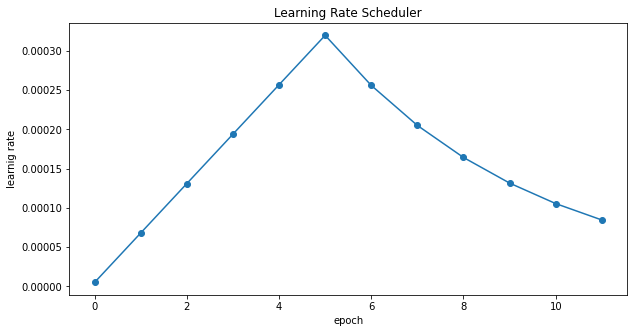

In [16]:
def get_lr_callback(batch_size=8, plot=False):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(EPOCHS[0]), [lrfn(epoch) for epoch in np.arange(EPOCHS[0])], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

_=get_lr_callback(BATCH_SIZES[0], plot=True )

# 9. Training 🚅
* Our model will be trained for the number of `FOLDS` and `EPOCHS` you chose in the configuration above. Each fold the model with lowest validation `AUC` will be saved and used to predict OOF and test. 

2021-12-23 02:31:04.789390: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:31:04.854356: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:31:04.924094: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:31:04.987402: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:31:05.057622: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#########################
#### FOLD 1
#### Image Size: (273, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
165527552/165527152 [==============================] - 2s 0us/step
#########################
Training...


2021-12-23 02:35:39.939220: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 74040, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640226939.935655586","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 74040, Output num: 0","grpc_status":3}


Loading best model...
Predicting OOF with TTA...


2021-12-23 02:51:34.686031: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 179775, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640227894.685931617","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 179775, Output num: 0","grpc_status":3}


Predicting Test with TTA...
#### FOLD 1 OOF AUC without TTA = 0.694, with TTA = 0.704


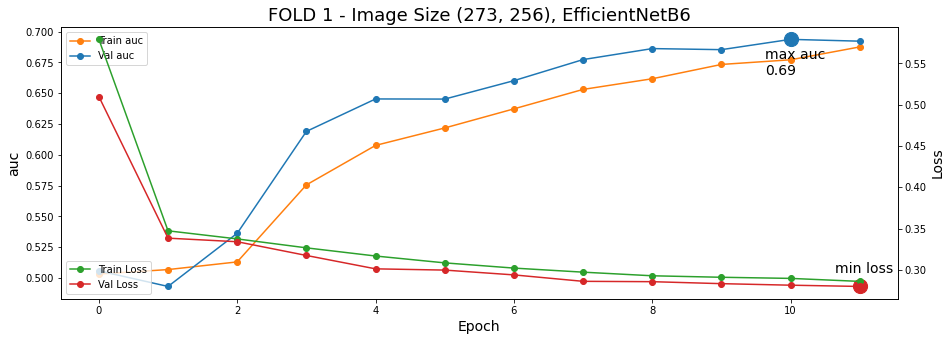

2021-12-23 02:55:37.850445: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:55:37.928359: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:55:37.998167: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:55:38.067380: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 02:55:38.139932: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#########################
#### FOLD 2
#### Image Size: (273, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...


2021-12-23 03:00:13.379026: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 278756, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640228413.378948346","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 278756, Output num: 1","grpc_status":3}


Loading best model...
Predicting OOF with TTA...


2021-12-23 03:16:22.912709: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 395611, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640229382.912618403","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 395611, Output num: 0","grpc_status":3}


Predicting Test with TTA...
#### FOLD 2 OOF AUC without TTA = 0.674, with TTA = 0.680


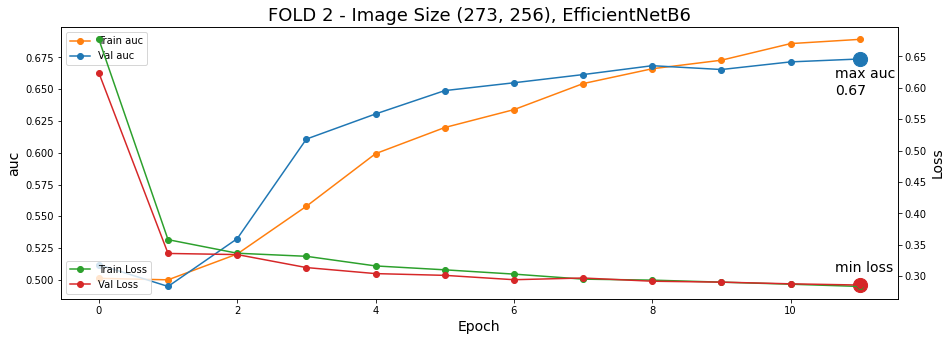

2021-12-23 03:20:24.780116: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:20:24.872240: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:20:24.941441: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:20:25.284139: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:20:25.373000: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#########################
#### FOLD 3
#### Image Size: (273, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...


2021-12-23 03:25:13.480067: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 510944, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640229913.479751454","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 510944, Output num: 0","grpc_status":3}


Loading best model...
Predicting OOF with TTA...


2021-12-23 03:41:20.609524: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 622239, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640230880.609328608","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 622239, Output num: 0","grpc_status":3}


Predicting Test with TTA...
#### FOLD 3 OOF AUC without TTA = 0.671, with TTA = 0.669


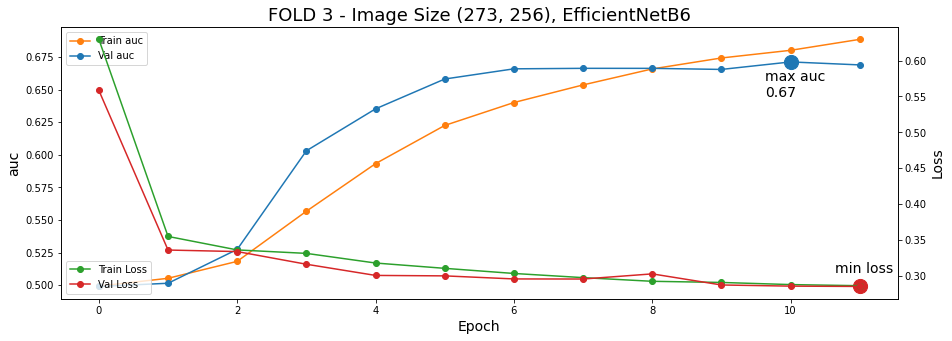

2021-12-23 03:45:23.773998: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:45:23.841152: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:45:23.910563: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:45:23.977477: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 03:45:24.048898: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#########################
#### FOLD 4
#### Image Size: (273, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...


2021-12-23 03:50:10.958435: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 737572, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640231410.958008393","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 737572, Output num: 0","grpc_status":3}


Loading best model...
Predicting OOF with TTA...


2021-12-23 04:06:21.363852: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 848867, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640232381.363715123","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 848867, Output num: 0","grpc_status":3}


Predicting Test with TTA...
#### FOLD 4 OOF AUC without TTA = 0.658, with TTA = 0.664


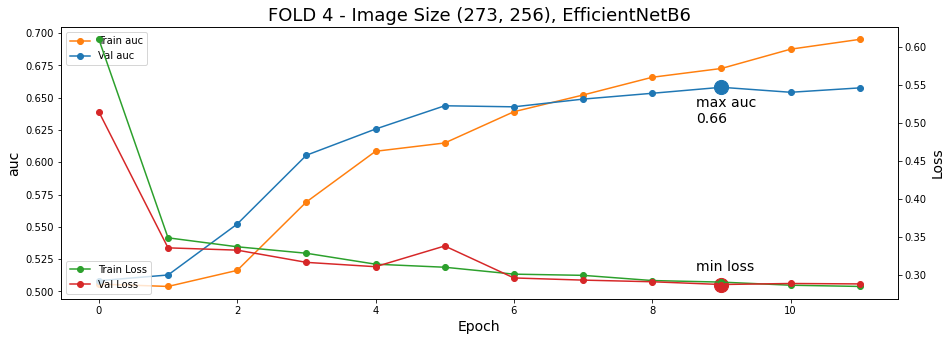

2021-12-23 04:10:25.082111: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 04:10:25.146870: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 04:10:25.214160: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 04:10:25.276956: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-23 04:10:25.344354: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


#########################
#### FOLD 5
#### Image Size: (273, 256) | model: EfficientNetB6 | batch_size 256
#### Training: 48000 | Validation: 12000
#########################
Training...


2021-12-23 04:15:07.103298: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 964200, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640232907.103229429","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 964200, Output num: 1","grpc_status":3}


Loading best model...
Predicting OOF with TTA...


2021-12-23 04:31:21.293661: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1086615, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640233881.293424551","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1086615, Output num: 0","grpc_status":3}


Predicting Test with TTA...
#### FOLD 5 OOF AUC without TTA = 0.670, with TTA = 0.680


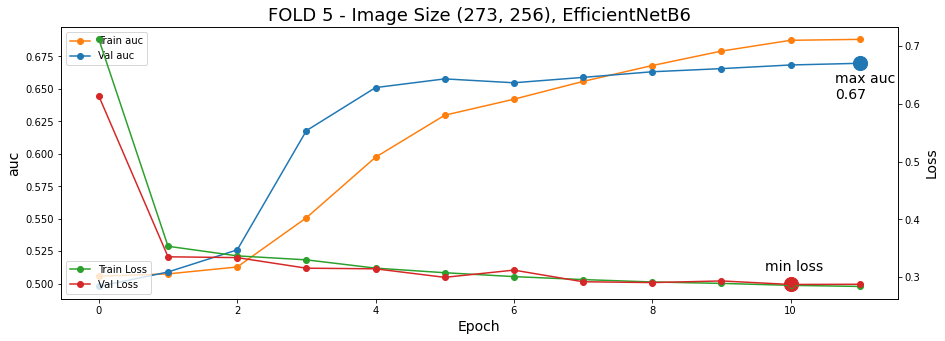

In [17]:
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_f1 = []; oof_ids = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(num_train_files))):
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    np.random.shuffle(files_train);
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size: (%i, %i) | model: %s | batch_size %i'%
          (IMG_SIZES[fold][0],IMG_SIZES[fold][1],EFNS[EFF_NETS[fold]].__name__,BATCH_SIZES[fold]*REPLICAS))
    train_images = count_data_items(files_train)
    val_images   = count_data_items(files_valid)
    print('#### Training: %i | Validation: %i'%(train_images, val_images))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
    print('#'*25)   
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=AUGMENT, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], 
        callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), 
        #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    # Loading best model for inference
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)  
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_ids=False,augment=AUGMENT,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND idS
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_ids=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_ids=True)
    oof_ids.append( np.array([img_id.numpy().decode("utf-8") for img, img_id in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_ids=False,augment=AUGMENT,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/2/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(history.history['auc'])),history.history['auc'],'-o',label='Train auc',color='#ff7f0e')
        plt.plot(np.arange(len(history.history['auc'])),history.history['val_auc'],'-o',label='Val auc',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('auc',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(len(history.history['auc'])),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(len(history.history['auc'])),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size (%i, %i), %s'%
                (fold+1,IMG_SIZES[fold][0],IMG_SIZES[fold][1],EFNS[EFF_NETS[fold]].__name__),size=18)
        plt.legend(loc=3)
        plt.savefig(f'fig{fold}.png')
        plt.show()

# 10. Calculate OOF 👀
The **OOF** (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the **OOF** to determine what are the best weights to blend your models with. Choose weights that maximize **OOF** `CV` score when used to blend **OOF**. Then use those same weights to blend your test predictions.

**Note**:
* Don't do blending just to climb **LB**, because most of the time it ends up getting overfitted.
* Try improving the **CV** by blending different model and you can keep an eye on the **LB**.
* As only`20%` data will be used for calculating **LB** score, relying on **CV** should be a safe option

In [18]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
ids = np.concatenate(oof_ids); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_id = ids, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.679


,image_id,target,pred,fold
0,707ec47b606a3d0,0,0.087327,0
1,743d0594f4e2ff7,0,0.063078,0
2,747d5a1f5ab25a9,0,0.086394,0
3,786909d18574aeb,0,0.052814,0
4,7726ef7381e86c7,0,0.128453,0


# 11. Post process 🍧
There are ways to modify predictions based on patient information to increase **CV**-**LB**. You can experiment with that here on your **OOF**.

# 12. Submission 👣

In [19]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_ids=True)

image_ids = np.array([img_id.numpy().decode("utf-8") 
                        for img, img_id in iter(ds.unbatch())])

2021-12-23 04:36:36.616994: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1191693, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1640234196.616784662","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1191693, Output num: 1","grpc_status":3}


In [20]:
submission = pd.DataFrame({'id':image_ids, 'target':preds[:,0]})
submission = submission.sort_values('id') 
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
27604,000bf832cae9ff1,0.098342
29604,000c74cc71a1140,0.080251
18754,000f5f9851161d3,0.089939
17054,000f7499e95aba6,0.118980
20854,00133ce6ec257f9,0.079248


## Prediction Distribution

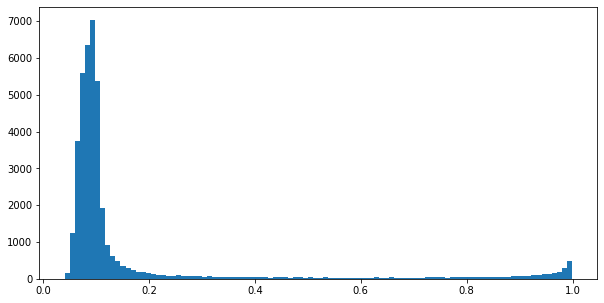

In [21]:
plt.figure(figsize=(10,5))
plt.hist(submission.target,bins=100);

# 13. Reference 💡
* Please Check this amazing notebook, [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords) by [Chris Deotte](https://www.kaggle.com/cdeotte)


## Please **Upvote** if you find this helpful 👽